# Car Model | Final Project
## Bachelor's degree in Economics

In [1]:
import pandas as pd
import numpy as np

In [2]:
car_model_fipe_xlsx = './car_model_fipe.xlsx'

df_car_model_fipe = pd.read_excel(car_model_fipe_xlsx, engine='openpyxl')

df_car_model_fipe.head()

,model,year_model,average_fipe_price,capacity_model,power_model,doors_model
0,Polo 1.0 Flex 12V 5p,2022,70403,10,12,5
1,Polo 1.0 Flex 12V 5p,2021,68144,10,12,5
2,Polo 1.0 Flex 12V 5p,2020,63417,10,12,5
3,Polo 1.0 Flex 12V 5p,2019,61870,10,12,5
4,Polo 1.0 Flex 12V 5p,2018,59891,10,12,5


In [3]:
from sklearn.model_selection import train_test_split

X = df_car_model_fipe.drop(columns=['average_fipe_price'])
y = df_car_model_fipe['average_fipe_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 
)

print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 142 entries, 158 to 102
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           142 non-null    object
 1   year_model      142 non-null    int64 
 2   capacity_model  142 non-null    int64 
 3   power_model     142 non-null    int64 
 4   doors_model     142 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 6.7+ KB
None


In [4]:
cat_features = ['model', 'year_model', 'capacity_model', 'power_model', 'doors_model']

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 142 entries, 158 to 102
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   model           142 non-null    category
 1   year_model      142 non-null    category
 2   capacity_model  142 non-null    category
 3   power_model     142 non-null    category
 4   doors_model     142 non-null    category
dtypes: category(5)
memory usage: 4.9 KB
None


In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6]
}

from catboost import CatBoostRegressor

catboost = CatBoostRegressor(
    cat_features=cat_features,
    verbose=0,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=catboost,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=2,
    error_score='raise'
)

grid_search.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error

best_model = grid_search.best_estimator_
print(f"Better parameters: {grid_search.best_params_}")

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE of CatBoost: {mae}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ........depth=4, iterations=100, learning_rate=0.05; total time=  11.5s
[CV] END ........depth=4, iterations=100, learning_rate=0.05; total time=  11.3s
[CV] END ........depth=4, iterations=100, learning_rate=0.05; total time=  10.4s
[CV] END ........depth=4, iterations=100, learning_rate=0.05; total time=  10.5s
[CV] END ........depth=4, iterations=100, learning_rate=0.05; total time=  10.9s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=  10.9s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=  11.7s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=  10.5s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=  10.1s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=  11.5s
[CV] END ........depth=4, iterations=200, learning_rate=0.05; total time=  21.8s
[CV] END ........depth=4, iterations=200, learnin

In [6]:
cat_features = ['model', 'year_model', 'capacity_model', 'power_model', 'doors_model']

for col in cat_features:
    df_car_model_fipe[col] = df_car_model_fipe[col].astype('category')

print(df_car_model_fipe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   model               178 non-null    category
 1   year_model          178 non-null    category
 2   average_fipe_price  178 non-null    int64   
 3   capacity_model      178 non-null    category
 4   power_model         178 non-null    category
 5   doors_model         178 non-null    category
dtypes: category(5), int64(1)
memory usage: 5.5 KB
None


In [7]:
cols = ['model', 'year_model', 'capacity_model', 'power_model', 'doors_model']
df_car_model_fipe_predict = df_car_model_fipe[cols].copy() 

df_car_model_fipe_predict['average_fipe_price'] = df_car_model_fipe['average_fipe_price']

df_car_model_fipe_predict['expected_price_ai'] = best_model.predict(df_car_model_fipe_predict)

print("Simulated ads with price suggested by AI:")
print(df_car_model_fipe_predict)

Simulated ads with price suggested by AI:
                                      model year_model capacity_model  \
0                      Polo 1.0 Flex 12V 5p       2022             10   
1                      Polo 1.0 Flex 12V 5p       2021             10   
2                      Polo 1.0 Flex 12V 5p       2020             10   
3                      Polo 1.0 Flex 12V 5p       2019             10   
4                      Polo 1.0 Flex 12V 5p       2018             10   
..                                      ...        ...            ...   
173              Polo Track 1.0 Flex 12V 5p       2023             10   
174       Polo Track Robust 1.0 Flex 12V 5p       2025             10   
175       Polo Track Robust 1.0 Flex 12V 5p       2025             10   
176  Polo Track Rock in Rio 1.0 Flex 12V 5p       2025             10   
177  Polo Track Rock in Rio 1.0 Flex 12V 5p       2025             10   

    power_model doors_model  average_fipe_price  expected_price_ai  
0           

In [8]:
def avaliar_preco_fipe(expected_price_ai, average_fipe_price):
    diff = abs(expected_price_ai - average_fipe_price) / average_fipe_price * 100
    if diff <= 10:
        return "Fair" # 🟢
    elif diff <= 20:
        return "Moderate" # 🟡
    else:
        return "Expensive" # 🔴

df_car_model_fipe_predict['lighthouse_fipe'] = df_car_model_fipe_predict.apply(lambda x: avaliar_preco_fipe(x['expected_price_ai'], x['average_fipe_price']), axis=1)

df_car_model_fipe_predict['anchor_price_fipe'] = df_car_model_fipe_predict['average_fipe_price'] * np.random.uniform(0.9, 1.2, len(df_car_model_fipe_predict))

def avaliar_preco_anchor_fipe(anchor_price_fipe, average_fipe_price):
    diff = abs(anchor_price_fipe - average_fipe_price) / average_fipe_price * 100
    if diff <= 10:
        return "Fair" # 🟢
    elif diff <= 20:
        return "Moderate" # 🟡
    else:
        return "Expensive" # 🔴

df_car_model_fipe_predict['lighthouse_anchor_fipe'] = df_car_model_fipe_predict.apply(lambda x: avaliar_preco_anchor_fipe(x['anchor_price_fipe'], x['average_fipe_price']), axis=1)

df_car_model_fipe_predict['anchor_price_ai'] = df_car_model_fipe_predict['expected_price_ai'] * np.random.uniform(0.9, 1.2, len(df_car_model_fipe_predict))

def avaliar_preco_anchor_ai(anchor_price_ai, average_fipe_price):
    diff = abs(anchor_price_ai - average_fipe_price) / average_fipe_price * 100
    if diff <= 10:
        return "Fair" # 🟢
    elif diff <= 20:
        return "Moderate" # 🟡
    else:
        return "Expensive" # 🔴

df_car_model_fipe_predict['lighthouse_anchor_ai'] = df_car_model_fipe_predict.apply(lambda x: avaliar_preco_anchor_ai(x['anchor_price_ai'], x['average_fipe_price']), axis=1)

print("\nTraffic light ads:")
print(df_car_model_fipe_predict)


Traffic light ads:
                                      model year_model capacity_model  \
0                      Polo 1.0 Flex 12V 5p       2022             10   
1                      Polo 1.0 Flex 12V 5p       2021             10   
2                      Polo 1.0 Flex 12V 5p       2020             10   
3                      Polo 1.0 Flex 12V 5p       2019             10   
4                      Polo 1.0 Flex 12V 5p       2018             10   
..                                      ...        ...            ...   
173              Polo Track 1.0 Flex 12V 5p       2023             10   
174       Polo Track Robust 1.0 Flex 12V 5p       2025             10   
175       Polo Track Robust 1.0 Flex 12V 5p       2025             10   
176  Polo Track Rock in Rio 1.0 Flex 12V 5p       2025             10   
177  Polo Track Rock in Rio 1.0 Flex 12V 5p       2025             10   

    power_model doors_model  average_fipe_price  expected_price_ai  \
0            12           5      

         Features  Importance (%)
3     power_model       53.751927
2  capacity_model       19.711158
1      year_model       14.248078
4     doors_model        9.215024
0           model        3.073813


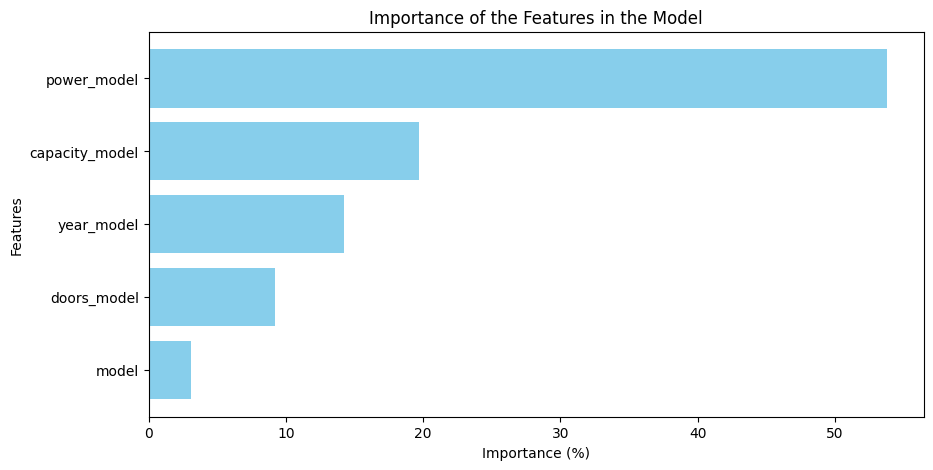

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = best_model.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Features': feature_names,
    'Importance (%)': (feature_importances / feature_importances.sum()) * 100
}).sort_values(by='Importance (%)', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 5))
plt.barh(importance_df['Features'], importance_df['Importance (%)'], color='skyblue')
plt.xlabel('Importance (%)')
plt.ylabel('Features')
plt.title('Importance of the Features in the Model')
plt.gca().invert_yaxis()
plt.show()

In [9]:
df_car_model_fipe_predict.to_excel("car_model_AI_XAI.xlsx", index=False, engine='openpyxl')

print("Extraction completed. File saved.")

Extraction completed. File saved.
